In [9]:
from astropy.io import fits
from astropy.table import Table, Column
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.convolution import Gaussian2DKernel,Tophat2DKernel,Gaussian1DKernel
from astropy.convolution import convolve, convolve_fft
from astropy.coordinates import SkyCoord
import glob
import os
from astropy.visualization import ZScaleInterval
import matplotlib.ticker as ticker

from matplotlib.gridspec import GridSpec
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from astropy.table import Table
import numpy as np
from scipy.optimize import curve_fit
import re
from matplotlib.patches import Circle
import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')
from scipy.integrate import simps
from scipy.interpolate import interp1d
# import sigma_clipping
from astropy.stats import sigma_clip,sigma_clipped_stats
import subprocess

def topcat_match(file1, file2, ra1, dec1, ra2, dec2,
                 radius_arcsec, output_file, join='1and2', matcher='sky', find='best'):
    """
    使用 TOPCAT 的 STILTS 命令行工具进行表匹配。

    参数:
        file1, file2: 输入 FITS 或 VOTable 文件路径
        ra1, dec1: file1 的 RA/Dec 列名
        ra2, dec2: file2 的 RA/Dec 列名
        radius_arcsec: 匹配半径（单位 arcsec）
        output_file: 输出文件路径
        join: 匹配模式，默认 '1and2'（交集），可选 '1', '2', '1or2'
        matcher: 匹配类型，默认 'sky'（天球）
        find: 匹配方式，'best'（最近）或 'all'（所有）
    """
    cmd = [
        '/usr/local/bin/stilts', 'tmatch2',
        f'in1={file1}', f'in2={file2}',
        f'matcher={matcher}',  # 天球匹配
        f'values1="{ra1} {dec1}"', f'values2="{ra2} {dec2}"',
        f'params={radius_arcsec}',
        f'join={join}',  # 控制输出的匹配记录
        f'find={find}',  # 'best' 或 'all'
        'ofmt=fits', f'out={output_file}'
    ]
    print("Running command:", " ".join(cmd))
    subprocess.run(" ".join(cmd), shell=True)

BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'
# define the absolute path of the current working directory
current_direc = os.getcwd() 


def draw_aper(ax, centerx, centery,phot_radius):
    c = Circle((centerx, centery ), float(phot_radius)/2, edgecolor='red', facecolor='None')
    ax.add_patch(c)
    return

# Define the linear model for fitting
def magnitude_model(log_lambda, beta, c):
    return -2.5 * (beta + 2) * log_lambda + c

def fit_beta(wavelengths, magnitudes, mag_errors):
    """
    Calculate the spectral slope (beta) using linear least-squares fitting.
    Parameters:
    wavelengths (array): Effective wavelengths of the filters.
    magnitudes (array): Observed magnitudes in the filters.
    mag_errors (array): Errors in the observed magnitudes.
    
    Returns:
    beta (float): Best-fit spectral slope.
    beta_err (float): Error in the spectral slope.
    """
    # Convert wavelengths to log scale
    log_wavelengths = np.log10(wavelengths)

    # Perform the fit
    popt, pcov = curve_fit(
        magnitude_model,
        log_wavelengths,
        magnitudes,
        # sigma=mag_errors,
        absolute_sigma=True
    )

    beta, c = popt
    beta_err = np.sqrt(pcov[0, 0])  # Error in beta
    return beta, beta_err, c

import numpy as np

def nJy_to_ABmag(flux, flux_error):
    """
    将流量 (nJy) 转换为 AB 星等，并计算误差。
    
    参数:
        flux (float or np.ndarray): 流量值，单位为 nJy。
        flux_error (float or np.ndarray): 流量的误差，单位为 nJy。
    
    返回:
        tuple: 星等 (magnitude) 和星等误差 (magnitude_error)。
    """
    # 防止非正流量导致对数计算报错
    flux = np.array(flux)
    flux_error = np.array(flux_error)
    
    # 仅对 flux > 0 计算
    valid = flux > 0
    magnitude = np.full_like(flux, np.nan, dtype=np.float64)  # 默认 NaN
    magnitude_error = np.full_like(flux, np.nan, dtype=np.float64)  # 默认 NaN
    
    if np.any(valid):
        magnitude[valid] = -2.5 * np.log10(flux[valid]) + 31.4
        magnitude_error[valid] = 2.5 / np.log(10) * (flux_error[valid] / flux[valid])
    
    return magnitude, magnitude_error

def match_sources_within_radius(catalog, target_id, radius=1):
    """
    Find sources within a given radius (in arcseconds) of a target source in the catalog.
    
    Parameters:
    - catalog (astropy.table.Table or pandas.DataFrame): The catalog containing source data.
    - target_id (int): The ID of the target source to match against.
    - radius (float): The radius within which to find matches (default: 1 arcsecond).
    
    Returns:
    - astropy.table.Table or pandas.DataFrame: Subset of the catalog with matching sources.
    """
    # Ensure the catalog is in the correct format
    if isinstance(catalog, pd.DataFrame):
        catalog = catalog.copy()
        ra_col, dec_col = catalog["RA"].values, catalog["DEC"].values
    else:  # Assuming astropy Table
        ra_col, dec_col = catalog["RA"], catalog["DEC"]

    # Get target source RA and DEC
    target_row = catalog[catalog["ID"] == target_id]
    if len(target_row) == 0:
        raise ValueError(f"Target ID {target_id} not found in the catalog.")
    target_ra = target_row["RA"][0]
    target_dec = target_row["DEC"][0]

    # Convert catalog to SkyCoord objects
    target_coord = SkyCoord(ra=target_ra * u.deg, dec=target_dec * u.deg)
    source_coords = SkyCoord(ra=ra_col * u.deg, dec=dec_col * u.deg)

    # Find sources within the radius
    sep = target_coord.separation(source_coords)
    matched_indices = sep.arcsecond <= radius

    # Return the matched sources
    return matched_indices

def binspec(wavelength, smoothspec, error, bin_width=5):

    # 创建新的波长数组，定义 bin 的中心点
    binned_wavelength = np.arange(wavelength[0], wavelength[-1], bin_width)

    # 初始化 binned 光谱和误差
    binned_spec = []
    binned_error = []

    # 对每个 bin 进行平均
    for i in range(len(binned_wavelength) - 1):
        # 找到属于当前 bin 的数据点
        idx = (wavelength >= binned_wavelength[i]) & (wavelength < binned_wavelength[i + 1])
        if np.any(idx):  # 确保有点落入 bin
            mean_value = np.mean(smoothspec[idx])  # 平均光谱值
            # 误差使用平方和的开方计算
            mean_error = np.sqrt(np.sum(error[idx]**2) / np.sum(idx))
            
            binned_spec.append(mean_value)
            binned_error.append(mean_error)
        else:
            binned_spec.append(np.nan)  # 如果 bin 没有数据，用 NaN 填充
            binned_error.append(np.nan)

    # 转换为 numpy 数组
    binned_spec = np.array(binned_spec)
    binned_error = np.array(binned_error)

    # 去除 NaN 的 bin（可选）
    valid_idx = ~np.isnan(binned_spec)
    binned_wavelength = binned_wavelength[:-1][valid_idx]
    binned_spec = binned_spec[valid_idx]
    binned_error = binned_error[valid_idx]

    return binned_wavelength, binned_spec, binned_error



msaexp version: 0.9.2


In [10]:

def draw_aper(ax, centerx, centery,phot_radius):
    c = Circle((centerx, centery ), float(phot_radius)/2, edgecolor='red', facecolor='None')
    ax.add_patch(c)
    return

# Define the linear model for fitting
def magnitude_model(log_lambda, beta, c):
    return -2.5 * (beta + 2) * log_lambda + c

def fit_beta(wavelengths, magnitudes, mag_errors):
    """
    Calculate the spectral slope (beta) using linear least-squares fitting.
    Parameters:
    wavelengths (array): Effective wavelengths of the filters.
    magnitudes (array): Observed magnitudes in the filters.
    mag_errors (array): Errors in the observed magnitudes.
    
    Returns:
    beta (float): Best-fit spectral slope.
    beta_err (float): Error in the spectral slope.
    """
    # Convert wavelengths to log scale
    log_wavelengths = np.log10(wavelengths)

    # Perform the fit
    popt, pcov = curve_fit(
        magnitude_model,
        log_wavelengths,
        magnitudes,
        # sigma=mag_errors,
        absolute_sigma=True
    )

    beta, c = popt
    beta_err = np.sqrt(pcov[0, 0])  # Error in beta
    return beta, beta_err, c

import numpy as np

def uJy_to_ABmag(flux, flux_error):
    """
    将流量 (nJy) 转换为 AB 星等，并计算误差。
    
    参数:
        flux (float or np.ndarray): 流量值，单位为 nJy。
        flux_error (float or np.ndarray): 流量的误差，单位为 nJy。
    
    返回:
        tuple: 星等 (magnitude) 和星等误差 (magnitude_error)。
    """
    # 防止非正流量导致对数计算报错
    flux = np.array(flux)
    flux_error = np.array(flux_error)
    
    # 仅对 flux > 0 计算
    valid = flux > 0
    magnitude = np.full_like(flux, np.nan, dtype=np.float64)  # 默认 NaN
    magnitude_error = np.full_like(flux, np.nan, dtype=np.float64)  # 默认 NaN
    
    if np.any(valid):
        magnitude[valid] = -2.5 * np.log10(flux[valid]) + 23.9
        magnitude_error[valid] = 2.5 / np.log(10) * (flux_error[valid] / flux[valid])
    
    return magnitude, magnitude_error

def match_sources_within_radius(catalog, target_id, radius=1):
    """
    Find sources within a given radius (in arcseconds) of a target source in the catalog.
    
    Parameters:
    - catalog (astropy.table.Table or pandas.DataFrame): The catalog containing source data.
    - target_id (int): The ID of the target source to match against.
    - radius (float): The radius within which to find matches (default: 1 arcsecond).
    
    Returns:
    - astropy.table.Table or pandas.DataFrame: Subset of the catalog with matching sources.
    """
    # Ensure the catalog is in the correct format
    if isinstance(catalog, pd.DataFrame):
        catalog = catalog.copy()
        ra_col, dec_col = catalog["RA"].values, catalog["DEC"].values
    else:  # Assuming astropy Table
        ra_col, dec_col = catalog["RA"], catalog["DEC"]

    # Get target source RA and DEC
    target_row = catalog[catalog["ID"] == target_id]
    if len(target_row) == 0:
        raise ValueError(f"Target ID {target_id} not found in the catalog.")
    target_ra = target_row["RA"][0]
    target_dec = target_row["DEC"][0]

    # Convert catalog to SkyCoord objects
    target_coord = SkyCoord(ra=target_ra * u.deg, dec=target_dec * u.deg)
    source_coords = SkyCoord(ra=ra_col * u.deg, dec=dec_col * u.deg)

    # Find sources within the radius
    sep = target_coord.separation(source_coords)
    matched_indices = sep.arcsecond <= radius

    # Return the matched sources
    return matched_indices

def plot_SED_src(large_subplot, df, name, symbol, color, factor=1.0):
    global filters_wavelength, NIRCAM_filter, kron_cols, kron_err_cols
    wavelengths = [filters_wavelength[band.upper()] for band in NIRCAM_filter]
    wavelengths = np.array(wavelengths)
    fluxes = df[kron_cols].values.flatten()
    flux_errors = df[kron_err_cols].values.flatten()
    mask = (fluxes > 0) & (flux_errors > 0)
    fluxes = fluxes[mask]
    flux_errors = flux_errors[mask]
    wavelengths = wavelengths[mask]
    goodfilters = NIRCAM_filter[mask]
    # NIRCAM_flux = NIRCAM_MAG
    # NIRCAM_fluxerr = NIRCAM_MAGerr
    # NIRCAM_flux = abmag_to_nJy(NIRCAM_MAG)#/1e3
    # NIRCAM_fluxerr = abmag_to_nJyerr(NIRCAM_MAG, NIRCAM_MAGerr)#/1e3
    # NIRCAM_wave = np.array(NIRCAMwave)[mask]
    # NIRCAM_flux = NIRCAM_flux[mask]
    # NIRCAM_fluxerr = NIRCAM_fluxerr[mask]
    large_subplot.errorbar(wavelengths, fluxes*factor, yerr=flux_errors, 
                           color=color, ecolor=color, fmt=symbol, markersize=20,
                           elinewidth=0.5, capsize=2, capthick=1, markerfacecolor='none', label = name, markeredgewidth=3)
    # large_subplot.scatter(restwave*(1+z), fnu/np.mean(fnu)*np.mean(NIRCAM_flux)*2.4, s=100, c='red', marker='x', label='Akin24 mean SED')
    large_subplot.tick_params(axis='both', which='major', labelsize=20, direction='in')
    large_subplot.set_xlabel(r'Observed Wavelength $(\mu \rm m)$', fontsize=20)
    # large_subplot.set_ylabel('MAG', fontsize=20)
    large_subplot.set_ylabel('Flux (nJy)', fontsize=20)
    large_subplot.set_yscale('log')
    large_subplot.set_xscale('log')
    large_subplot.set_xticks([1,1.5,2,3,4,5])
    large_subplot.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    large_subplot.minorticks_off()
    
    return wavelengths,fluxes,flux_errors,goodfilters

In [12]:
def read_filter_data(filename):
    data = np.loadtxt(filename, skiprows=1)
    wavelength = data[:, 0]
    throughput = data[:, 1]
    return wavelength, throughput

def calculate_photflux(spec_wavelength, spec_flux ,band , redshift = 0):
    # 定义波段
    # fluxes = {}
    spec_wavelength = spec_wavelength * (1 + redshift)
    spec_flux = spec_flux / (1 + redshift)

    
    # 读取滤光片透过率
    file = '../nircam_throughputs/mean_throughputs/' + band.upper() + '_throughput.txt'
    wavelength, throughput = read_filter_data(file)
    # 对透过率进行插值，使其与 spec_wavelength 匹配
    wavelength = wavelength/1e4
    throughput_interpolated = np.interp(spec_wavelength, wavelength, throughput, left=0, right=0)
    # print(throughput)
    # 计算流量（积分）
    flux = simps(spec_flux * throughput_interpolated, spec_wavelength)

    return flux

def mark_emission_lines(ax,z):
    lines = {
    '[O II]': 0.3727,      # [OII] 双峰 (合并值)
    'Hγ': 0.4340,         # Hγ
    '[O III]': 0.5007,     # [OIII]
    'Hβ': 0.4861,         # Hβ
    'Hα': 0.6563,         # Hα
    'Paα': 1.8756,        # Paschen-alpha (Paα)

}
    for line, rest_wave in lines.items():
        # for z in [5.5, 7.5]:  # 以两个红移值为例
        obs_wave = rest_wave * (1 + z)
        if obs_wave < 0.7 or obs_wave > 5.0:
            continue
        ax.axvline(obs_wave, linestyle='--', color='grey')
        ax.text(obs_wave, 1, f'{line}', rotation=90, verticalalignment='bottom',fontsize=16)
fsize = 15
tsize = 15
tdir = 'in'
major = 18.0
minor = 16.0
lwidth = 0.8
lhandle = 2.0
labelpad = 5.5

%matplotlib inline
#%matplotlib qt5
fontsize= 21
tsize = 15
tdir = 'in'
major = 7.0
minor = 4.0
lwidth = 2
lhandle = 2.0
labelpad = 5.5
spiwidth = 2

plt.style.use('default')
#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['xtick.major.width'] = lwidth
plt.rcParams['ytick.major.width'] = lwidth
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True


In [22]:
cataloglist = ['../catalog/all_lrd_catalog_unique.txt',
               '../catalog/DJA_NIRSpec_withphot.csv'
               ]

zphotcataloglist = ['../catalogg/all_lrd_catalog.txt',
                    '../catalog/DJA_NIRSpec_withphot.csv'
                    ]

savepath = '/Users/zijianzhang/Astro_Data/LRD_SPEC/LRD_selection/'

In [23]:
all_astrodeep_src = Table.read('../catalog/ASTRODEEP_full_combine.fits')
all_astrodeep_src['F444W'] = uJy_to_ABmag(all_astrodeep_src['f_f444w'], all_astrodeep_src['e_f444w'])[0]
all_astrodeep_src['F444W_err'] = uJy_to_ABmag(all_astrodeep_src['f_f444w'], all_astrodeep_src['e_f444w'])[1]

mask = (all_astrodeep_src['F444W']/all_astrodeep_src['F444W_err'] > 10)*(all_astrodeep_src['flags_SE'] == 0)
astrodeep_src = all_astrodeep_src[mask]

In [24]:

# 定义波长对应的中心值（单位：微米）
# filter_wavelengths = {
#     "F606W": 0.606, "F814W": 0.814, "F115W": 1.15,
#     "F150W": 1.50, "F200W": 2.00, "F277W": 2.77,
#     "F356W": 3.56, "F410M": 4.10, "F444W": 4.44
# }
filter_wavelengths = {
    'F070W': 0.7, 'F090W': 0.9, 'F115W': 1.15,  'F150W': 1.5, 'F164N': 1.64, 'F105W': 1.055025, 'F125W': 1.248607, 'F140W': 1.392321, 'F160W': 1.537034, 
     'F200W': 2.0,'F277W': 2.77,  'F162M': 1.62, 'F182M': 1.82, "F187N": 1.87,
    'F300M': 3.0, 'F335M': 3.35, 'F356W': 3.56, 'F360M': 3.6, 'F210M': 2.1, 'F250M': 2.5, 'F410M': 4.1, 'F430M': 4.3, 'F140M': 1.4, 
    'F444W': 4.44, 'F460M': 4.6, 'F480M': 4.8, 'F435W': 0.435, 'F606W': 0.606, 'F775W': 0.775, 'F814W': 0.814
}

# 定义红移范围与波段
redshift_bands = [
    (2.0, 3.25, ["F606W", "F814W", "F115W"], ["F150W", "F200W", "F277W"]),
    (3.25, 4.75, ["F814W", "F115W", "F150W"], ["F200W", "F277W", "F356W"]),
    (4.75, 8.0, ["F115W", "F150W", "F200W"], ["F277W", "F356W", "F444W"]),
    (8.0, np.inf, ["F150W", "F200W", "F277W"], ["F356W", "F444W"])
]

# 定义拟合函数：f_lambda = lambda^beta
def power_law(wavelength, beta, c):
    return c * wavelength**beta

# 定义函数计算 β
def calculate_beta(filters, row, lowestsnr = 1):
    wavelengths = np.array([filter_wavelengths[f.upper()] for f in filters])
    fluxes = np.array([row[f"f_{f.lower()}"] for f in filters])
    errors = np.array([row[f"e_{f.lower()}"] for f in filters])
    
    # fluxes = np.array([row[f"{f}_CIRC2"] for f in filters])
    # errors = np.array([row[f"{f}_CIRC2_e"] for f in filters])
    # 过滤掉无效数据（flux和error均需为正）
    # valid = (fluxes > 0) & (errors > 0)
    valid = (fluxes > 0) & (errors > 0) & (fluxes/errors > lowestsnr)
    wavelengths = wavelengths[valid]
    fluxes = fluxes[valid]
    errors = errors[valid]
    magnitudes, mag_errors = nJy_to_ABmag(fluxes, errors)
    
    if len(wavelengths) < 2:  # 至少需要两个点才能拟合
        return -99

    try:
        # 使用curve_fit进行拟合
        popt = fit_beta(wavelengths, magnitudes, mag_errors)
        beta = popt[0]  # 拟合的beta值
    except RuntimeError:
        beta = -99  # 如果拟合失败，返回None
    
    return beta



In [25]:
ii = 1

catalog = Table.read(cataloglist[ii], format='ascii')
Grating = np.array([i.split('_')[1] for i in catalog['file']])
zphotcatalog = Table.read(zphotcataloglist[ii], format='ascii')
catalog = catalog[(catalog['z'] > 2) * (Grating == 'prism-clear')]
# zphotcatalog = zphotcatalog[zphotcatalog['z'] > 4]


uniuid = np.unique(catalog['uid'])
nrs = Table.read('../catalog/DJA_NIRSpec.csv')

print('number of sources:', len(uniuid))

bands = []
for key in catalog.keys():
    if key.startswith('f_f'):
        bands.append(key.split('_')[1])
# bands.sort()
bands = np.array(bands)
bands_wave = np.array([filter_wavelengths[f.upper()] for f in bands])
sortind = bands_wave.argsort()
bands_wave = bands_wave[sortind]
bands = bands[sortind]
NIRCAM_filter = bands
kron_cols = [f"f_{band}" for band in NIRCAM_filter]
kron_err_cols = [f"e_{band}" for band in NIRCAM_filter]

number of sources: 5444


In [26]:
band_limits = {
    'f435w':(0.3765, 0.4805),
    'f606w':(0.4695, 0.7095),
    'f775w':(0.6935, 0.8545),
    'f814w':(0.7025, 0.9471),
    'f090w':(0.7935, 1.0075),
    'f105w':(0.9035, 1.2015),
    'f115w':(1.0082, 1.2851),
    'f125w':(1.0955, 1.4035),
    'f140w':(1.1970, 1.5990),
    'f150w':(1.3257, 1.6737),
    'f160w':(1.3965, 1.6905),
    'f200w':(1.7474, 2.2373),
    'f277w':(2.4019, 3.1477),
    'f356w':(3.1132, 4.0118),
    'f410m':(3.8374, 4.3320),
    'f444w':(3.8577, 5.0427)}

# 发射线波长（单位为埃）
lines = {
    "Hbeta_OIII_complex": (0.4861, 0.5007),  # 包含 Hβ 和 [OIII]
    "Halpha": 0.6563                      # Hα
}
def identify_lines_with_redshift(band_limits, lines, redshift):
    """
    根据源的红移，识别波段中是否包含指定发射线。

    :param band_limits: dict, 波段的名称和波长范围
    :param lines: dict, 发射线名称和波长
    :param redshift: float, 天体的红移值
    :return: dict, 每个波段对应的包含发射线的情况
    """
    result = {}
    for band, (low, high) in band_limits.items():
        result[band] = []
        for line_name, wavelength in lines.items():
            # 红移后的波长范围
            if isinstance(wavelength, tuple):
                wavelength_obs = (wavelength[0] * (1 + redshift), wavelength[1] * (1 + redshift))
            else:
                wavelength_obs = wavelength * (1 + redshift)
            
            # 判断红移后的波长是否在波段范围内
            if isinstance(wavelength_obs, tuple):
                if low <= wavelength_obs[0] <= high or low <= wavelength_obs[1] <= high or (wavelength_obs[0] < low and wavelength_obs[1] > high):
                    result[band].append(line_name)
            else:
                if low <= wavelength_obs <= high:
                    result[band].append(line_name)
    contamin_bands = []
    # 打印结果
    for band, contained_lines in result.items():
        if contained_lines:
            # print(f"{band}: contains {', '.join(contained_lines)} at redshift {redshift}")
            contamin_bands.append(band)
    # print(contamin_bands)
    
    return contamin_bands

# redshift = z
# contamin_bands = identify_lines_with_redshift(band_limits, lines, redshift)
# print(contamin_bands)



# 定义局部插值函数
# def interpolate_continuity(w, f, mask_region):
#     """在指定区域进行线性插值"""
#     start, end = mask_region
#     region_mask = (w >= start) & (w <= end)
    
#     # 获取屏蔽区域外的数据点
#     left_idx = np.where(w < start)[0]
#     right_idx = np.where(w > end)[0]
    
#     if len(left_idx) == 0 or len(right_idx) == 0:
#         return f  # 如果处于边界则返回原数据
    
#     # 合并左右连续区域的数据
#     cont_w = np.concatenate([w[left_idx], w[right_idx]])
#     cont_f = np.concatenate([f[left_idx], f[right_idx]])
    
#     # 创建插值函数
#     interp_func = interp1d(cont_w, cont_f, kind='linear', 
#                           fill_value='extrapolate')
    
#     # 替换屏蔽区域的flux
#     f_clean = f.copy()
#     f_clean[region_mask] = interp_func(w[region_mask])
#     return f_clean

# plt.plot(sp.spec_wobs, sp.spec['flux']* sp.spec['to_flam'])
# for c in ['flux','err','full_err']:
#     plt.plot(sp.spec_wobs, sp.spec[c], alpha=0.5, label=c)
#     import numpy as np

def keep_longest_true_segment(arr):
    # 找到所有连续True段的起始和结束索引
    diff = np.diff(np.concatenate(([0], arr, [0])))  # 添加头尾0以方便识别边界
    starts = np.where(diff == 1)[0]  # 识别True段的起始位置
    ends = np.where(diff == -1)[0]   # 识别True段的结束位置
    
    if len(starts) == 0:  # 如果没有True值
        return arr

    # 计算每一段True的长度
    lengths = ends - starts
    
    # 找到最长的True段
    max_len_idx = np.argmax(lengths)
    
    # 创建一个新的数组，只保留最长的True段
    result = np.zeros_like(arr, dtype=bool)
    result[starts[max_len_idx]:ends[max_len_idx]] = True
    return result


def interpolate_continuity(w, f, mask_region, left_window=20e-2, right_window=20e-2, print_win=False):
    """用两端指定波长范围内的数据拟合一条直线替代发射线区域"""
    start, end = mask_region
    region_mask = (w >= start) & (w <= end)
    
    # 计算左右窗口范围
    left_win_start = start - left_window
    left_win_end = start
    right_win_start = end
    right_win_end = end + right_window
    if(print_win):
        print('left_win_start:', left_win_start)
        print('left_win_end:', left_win_end)
        print('right_win_start:', right_win_start)
        print('right_win_end:', right_win_end)
    
    # 提取左右窗口数据
    left_mask = (w >= left_win_start) & (w <= left_win_end)
    right_mask = (w >= right_win_start) & (w <= right_win_end)
    
    # 提取左右窗口的波长和对应的值
    left_wavelength = w[left_mask]
    left_flux = f[left_mask]
    
    right_wavelength = w[right_mask]
    right_flux = f[right_mask]
    
    # 将左右数据合并
    all_wavelength = np.concatenate([left_wavelength, right_wavelength])
    all_flux = np.concatenate([left_flux, right_flux])
    
    # 用多项式拟合一条直线（同时拟合左边和右边的数据）
    coeff = np.polyfit(all_wavelength, all_flux, 2)  # 拟合左边和右边数据
    
    # 生成线性插值函数（使用拟合的系数）
    # interp_func = interp1d(
    #     [start, end], 
    #     [np.polyval(coeff, start), np.polyval(coeff, end)],
    #     kind='linear',
    #     fill_value='extrapolate'
    # )
    
    # 替换发射线区域
    f_clean = f.copy()
    # f_clean[region_mask] = interp_func(w[region_mask])
    interped = np.polyval(coeff, w[region_mask])
    interped[interped>f[region_mask]] = f[region_mask][interped>f[region_mask]]
    f_clean[region_mask] = interped#np.polyval(coeff, w[region_mask])
    
    return f_clean

def get_linecorrect_ratio(sp, band,z, savecorpath = None, ifshow = False, print_win = False):
    lines_rest = {
        'Ha': 0.65630,       # 单位：Å (Hα)
        'Hb': 0.49510,       # 单位：Å (Hβ)
    
    }
    delta_rest = 200/1e4  # 静止帧中屏蔽线周围±50Å的范围

    # wavelength, flux_original, error = binspec(sp.spec_wobs, sp.spec['flux']* sp.spec['to_flam'], sp.spec['err']* sp.spec['to_flam'], bin_width=0.004)
    wavelength, flux_original, error = sp.spec_wobs, sp.spec['flux']* sp.spec['to_flam'], sp.spec['err']* sp.spec['to_flam']
    valid = keep_longest_true_segment(sp.valid)
    wavelength = wavelength[valid]
    flux_original = flux_original[valid]
    error = error[valid]
    # flux_original = convolve(flux_original, Gaussian1DKernel(1))
    # remove bad spixels
    mask = (flux_original > 0) & (error > 0) & np.isfinite(flux_original) & np.isfinite(error) #& (flux_original/error > 0.5)
    wavelength = wavelength[mask]
    flux_original = flux_original[mask]
    flux_clean = flux_original.copy()  # 创建副本用于修改
        # 计算观测帧中的波长范围
    mask_regions = []
    for name, lambda_rest in lines_rest.items():
        lambda_obs_center = lambda_rest * (1 + z)
        delta_obs = delta_rest * (1 + z)  # 红移后的屏蔽范围
        if( lambda_obs_center - delta_obs <wavelength[0] or lambda_obs_center + delta_obs > wavelength[-1]):
            continue

        mask_regions.append( (lambda_obs_center - delta_obs, 
                             lambda_obs_center + delta_obs) )

    # 对每个发射线区域进行处理
    # print('mask_regions:', mask_regions)
    for region in mask_regions:
        flux_clean = interpolate_continuity(wavelength, flux_clean, region, print_win = print_win)

    if(savecorpath is not None):
        # 绘制结果对比
        plt.figure(figsize=(12, 6))
        plt.plot(wavelength, flux_original, alpha=0.7, label='Original Spectrum')
        # plt.plot(sp.spec_wobs, sp.spec[c]*sp.spec['to_flam'])
        plt.plot(wavelength, flux_clean, alpha=0.7, label='Line-subtracted')
        for line in lines_rest.values():
            plt.axvline(line * (1 + z), linestyle='--', color='grey')
        # plt.axvline(region[0], linestyle='--', color='red', label='Mask Region')
        # plt.axvline(region[1], linestyle='--', color='red')
        plt.xlabel('Wavelength (Å)')
        plt.ylabel(r'F$_\lambda$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
        plt.title('Spectrum Before and After Emission Line Subtraction')
        plt.yscale('log')
        plt.legend()
        
        plt.savefig(savecorpath, dpi=300, bbox_inches='tight')
        if(ifshow):
            plt.show()
        plt.close()

    ori_phot = calculate_photflux(wavelength, flux_original, band = band)
    clean_phot = calculate_photflux(wavelength, flux_clean, band = band)
    ratio = clean_phot / ori_phot
    return min(ratio, 1.0), (wavelength, flux_original), (wavelength, flux_clean)



def power_law(wavelength, A, alpha):
    """幂律连续谱模型"""
    return A * (wavelength ** alpha)

def get_linecorrect_ratio2(sp, band, z, savecorpath=None, ifshow=False, print_win=False):
    # 初始化参数和数据结构
    lines_rest = {'Ha': 0.65630, 'Hb': 0.49510}
    delta_rest = 200/1e4

    # 获取波段响应范围
    # 读取滤光片透过率
    file = '/Users/zijianzhang/Astro_Data/LRD_SPEC/nircam_throughputs/mean_throughputs/' + band.upper() + '_throughput.txt'
    wave_filter, throughput_filter = read_filter_data(file)
    # 对透过率进行插值，使其与 spec_wavelength 匹配
    wave_filter = wave_filter/1e4
    band_wave = np.array(wave_filter)  # 假设band对象包含波长和传输率
    band_trans = np.array(throughput_filter)
    valid_trans = band_trans > 0.001*np.max(band_trans)
    wave_interval = np.max(band_wave[valid_trans]) - np.min(band_wave[valid_trans])
    wave_range = (np.min(band_wave[valid_trans])) - 0.7*wave_interval, np.max(band_wave[valid_trans])+0.7*wave_interval

    # 数据预处理
    wavelength = sp.spec_wobs
    flux_original = sp.spec['flux'] * sp.spec['to_flam']
    error = sp.spec['err'] * sp.spec['to_flam']
    
    valid = keep_longest_true_segment(sp.valid)
    mask = valid & (flux_original > 0) & (error > 0) & np.isfinite(flux_original) & np.isfinite(error)
    wavelength, flux_original, error = wavelength[mask], flux_original[mask], error[mask]

    # 生成波段范围掩码
    in_band = (wavelength >= wave_range[0]) & (wavelength <= wave_range[1])
    A, alpha = 1e-17, -2  # 默认值


    # 创建初始拟合掩码（仅在波段范围内且排除发射线区域）
    fit_mask = in_band.copy()
    line_regions = []
    for name, lambda_rest in lines_rest.items():
        lambda_obs_center = lambda_rest * (1 + z)
        delta_obs = delta_rest * (1 + z)
        line_regions.append( (lambda_obs_center - delta_obs, lambda_obs_center + delta_obs) )
        if wave_range[0] <= lambda_obs_center <= wave_range[1]:
            fit_mask &= ~((wavelength >= lambda_obs_center - delta_obs) & 
                         (wavelength <= lambda_obs_center + delta_obs))

    # 迭代拟合流程（仅在波段范围内）
    bad_pixels = np.zeros_like(wavelength, dtype=bool)
    max_iter = 5
    tolerance = 2.5
    
    for _ in range(max_iter):
        current_mask = fit_mask & ~bad_pixels & in_band  # 关键修改：限制在波段内
        x_fit = wavelength[current_mask]
        y_fit = flux_original[current_mask]
        y_err = error[current_mask]
        
        if len(x_fit) < 2: break
        
        # 幂律参数初始化
        try:
            log_coeffs = np.polyfit(np.log(x_fit[y_fit>0]), np.log(y_fit[y_fit>0]), 1)
            p0 = [np.exp(log_coeffs[1]), log_coeffs[0]]
        except:
            p0 = [1e-17, -2]

        # 加权拟合
        try:
            popt, _ = curve_fit(power_law, x_fit, y_fit, sigma=y_err, 
                              p0=p0, bounds=([1e-20, -5], [1e-10, 2]))
            A, alpha = popt
        except:
            A, alpha = p0

        # 检测坏像素（仅在波段范围内）
        residuals = flux_original - power_law(wavelength, A, alpha)
        # residual_sigma = residuals #/ error
        residual_sigma_rms = np.std(residuals[current_mask])
        # print('residual_sigma_rms:', residual_sigma_rms)
        # print('residual_sigma_num:', np.min(residuals[current_mask].value/residual_sigma_rms))
        new_bad = (residuals/residual_sigma_rms < -tolerance) & in_band & current_mask
        if not np.any(new_bad): break
        bad_pixels |= new_bad

    # 生成修正光谱（仅在波段范围内替换）
    flux_clean = flux_original.copy()
    flux_original_new = flux_original.copy()
    band_replace_mask = ~current_mask & in_band #& (bad_pixels | ~fit_mask)
    flux_clean[band_replace_mask] = power_law(wavelength[band_replace_mask], A, alpha)
    cont_mask = in_band*(flux_original_new<=flux_clean)
    flux_original_new[cont_mask] = power_law(wavelength[cont_mask], A, alpha)
    band_replace_mask =  in_band #& (bad_pixels | ~fit_mask)
    flux_clean[band_replace_mask] = power_law(wavelength[band_replace_mask], A, alpha)


    # 可视化（新增波段范围标注）
    if savecorpath is not None:
        plt.figure(figsize=(14, 6))
        
        # 绘制原始和修正光谱
        plt.plot(wavelength, flux_original, 'k--', alpha=0.5, label='Original')
        plt.plot(wavelength, flux_original_new, 'r-', alpha=0.7, label='corrected')
        plt.plot(wavelength, flux_clean, 'b-', alpha=0.7, label='line-subtracted')
        
        
        # 突出显示波段范围内的拟合
        band_fit_wave = wavelength[in_band]
        band_fit_model = power_law(band_fit_wave, A, alpha)
        plt.plot(band_fit_wave, band_fit_model, 'r--', lw=2, 
                label='Band Power-law Fit')
        
        # 标记替换区域
        replace_points = wavelength[bad_pixels]
        plt.scatter(replace_points, flux_original[bad_pixels],
                   c='none', edgecolors='orange', s=30, label='Replaced Pixels')
        
        # 波段范围标注
        plt.axvspan(*wave_range, color='green', alpha=0.1, label='Filter Range')
        
        # 发射线标注
        for name, lambda_rest in lines_rest.items():
            obs_line = lambda_rest*(1+z)
            if wave_range[0] <= obs_line <= wave_range[1]:
                plt.axvline(obs_line, ls=':', c='purple', alpha=0.7)
        
        plt.xlabel('Wavelength (Å)')
        plt.ylabel(r'F$_\lambda$')
        plt.yscale('log')
        plt.legend(ncol=2, loc='lower right')
        plt.title(f"Spectral Correction in {band} Band")
        plt.savefig(savecorpath, dpi=150, bbox_inches='tight')
        if ifshow: plt.show()
        plt.close()

    # 计算流量比（仅在波段范围内）
    ori_phot = calculate_photflux(wavelength, flux_original, band)
    clean_phot = calculate_photflux(wavelength, flux_clean, band)
    return min(clean_phot / ori_phot, 1.0)



In [27]:
catalog

jname,ndup,uid,ra,dec,file,root,srcid,nGr,Grating,grade,zfit,z,comment,References,nRef,sn50,wmin,wmax,Lya,Ha,OIII,L_Ha,L_OIII,HST,NIRCam,slit,FITS,Fnu,Flam,ID_1,RA_1,DEC_1,X,Y,isoarea_SE,class_starSE,flags_SE,r50_SE,f_autoSE,e_autoSE,a_f001w,ell_f001w,theta_f001w,rKron_f001w,f_f435w,f_f606w,f_f775w,f_f814w,f_f105w,f_f125w,f_f140w,f_f160w,f_f090w,f_f115w,f_f150w,f_f200w,f_f277w,f_f356w,f_f410m,f_f444w,e_f435w,e_f606w,e_f775w,e_f814w,e_f105w,e_f125w,e_f140w,e_f160w,e_f090w,e_f115w,e_f150w,e_f200w,e_f277w,e_f356w,e_f410m,e_f444w,apopt,flag_1,ID_2,RA_2,DEC_2,zspec,zphot,EAzY_eazy_v13,EAzY_Larson,EAzY_LarsonLyaRed,flag_2,Separation_2,GroupID,GroupSize,Separation
str20,int64,int64,float64,float64,str55,str22,int64,int64,str29,int64,float64,float64,str138,str86,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str17,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,int64,float64
j001424.92m302256.05,6,21979,3.603845,-30.382235,abell2744-ddt-v3_prism-clear_2756_100001.spec.fits,abell2744-ddt-v3,100001,0,--,3,7.8774,7.8774,Redshifts match v2 grade=3,KNa23 z=7.874,1,2.32,0.6,5.29,-1.5,--,--,--,42.48,--,--,--,FITS zfit spl,--,--,16426,3.603884,-30.382261,7612.022,9853.741,2211.0,0.03,18.0,13.615,0.40603,0.0052,21.006403,0.664409,6.125186,168.051224,-0.00971,-0.00373,0.0,0.00676,0.03388,0.14372,0.15602,0.2045,0.0,0.08372,0.18125,0.21196,0.25873,0.36631,0.3705,0.46322,0.01087,0.00897,-99.0,0.0069,0.0072,0.01051,0.0098,0.00945,-99.0,0.01252,0.01025,0.00989,0.00574,0.00612,0.0115,0.00803,0.33,311,16426,3.603884,-30.382261,7.88,7.88,7.88,7.88,7.88,311,0.0,1,6,0.1530710757160626
j001424.81m302256.06,1,10709,3.603377,-30.382238,abell2744-ddt-v3_prism-clear_2756_100002.spec.fits,abell2744-ddt-v3,100002,0,--,3,7.88,7.88,Redshifts match v2 grade=3,TMo22 z=7.877,1,1.4,0.6,5.29,-1.7,--,--,--,42.22,--,--,--,FITS zfit spl,--,--,16608,3.603393,-30.382242,7661.129,9855.855,249.0,0.26,3.0,5.331,0.12668,0.00129,4.136701,0.145067,-5.614621,33.093605,-0.00236,0.00359,0.0,0.00034,0.01773,0.05761,0.0691,0.07134,0.0,0.04438,0.06857,0.06426,0.06743,0.10069,0.11431,0.11762,0.00254,0.00213,-99.0,0.0016,0.00188,0.00278,0.0026,0.00252,-99.0,0.00299,0.00245,0.0024,0.00134,0.00149,0.00274,0.00187,0.28,311,16608,3.603393,-30.382242,7.877,7.877,7.877,7.877,7.877,311,0.0,--,--,0.05173430385853116
j001425.57m302251.52,5,21980,3.606571,-30.380932,abell2744-ddt-v3_prism-clear_2756_100004.spec.fits,abell2744-ddt-v3,100004,0,--,3,7.8803,7.8803,;,TMo22 z=7.884,1,0.8,0.6,5.29,-0.2,--,--,--,42.65,--,--,--,FITS zfit spl,--,--,17017,3.606567,-30.380902,7343.735,10011.061,553.0,0.03,3.0,6.668,0.12388,0.00223,5.434963,0.071889,68.693354,43.479702,-0.00098,-0.00126,0.0,-0.00194,0.01288,0.04676,0.05113,0.06332,0.0,0.03251,0.0536,0.05584,0.06069,0.08936,0.09048,0.12026,0.00302,0.0026,-99.0,0.0019,0.00231,0.00334,0.00311,0.003,-99.0,0.00396,0.00322,0.00316,0.00159,0.00175,0.00322,0.00225,0.33,311,17017,3.606567,-30.380902,7.884,7.884,7.884,7.884,7.884,311,0.0,--,--,0.108712104057194
j001425.92m302351.94,1,10710,3.608015,-30.397762,abell2744-ddt-v3_prism-clear_2756_10018.spec.fits,abell2744-ddt-v3,10018,0,--,1,6.4666,6.4666,--,-,0,0.83,0.6,5.29,1.3,2.9,--,41.63,--,--,--,--,FITS zfit spl,--,--,11771,3.608024,-30.39771,7199.0,8063.382,316.0,0.04,2.0,4.602,0.04974,0.00167,4.125838,0.158262,50.996885,33.006702,-0.00286,-0.00185,0.0,0.00054,0.02511,0.02336,0.01691,0.01979,0.0,0.02041,0.02086,0.01762,0.02596,0.04288,0.03079,0.03404,0.0022,0.0017,-99.0,0.00132,0.00212,0.00312,0.00288,0.00281,-99.0,0.00215,0.0018,0.00168,0.001,0.0010

  0%|          | 0/1 [00:00<?, ?it/s]

short bands: ['f115w' 'f125w' 'f140w' 'f150w' 'f160w' 'f200w' 'f277w']
long bands: ['f277w' 'f356w' 'f410m' 'f444w']
ID: 666, z: 6.859, beta_UV: -1.772984620340224, beta_opt: -5.4950810962281675


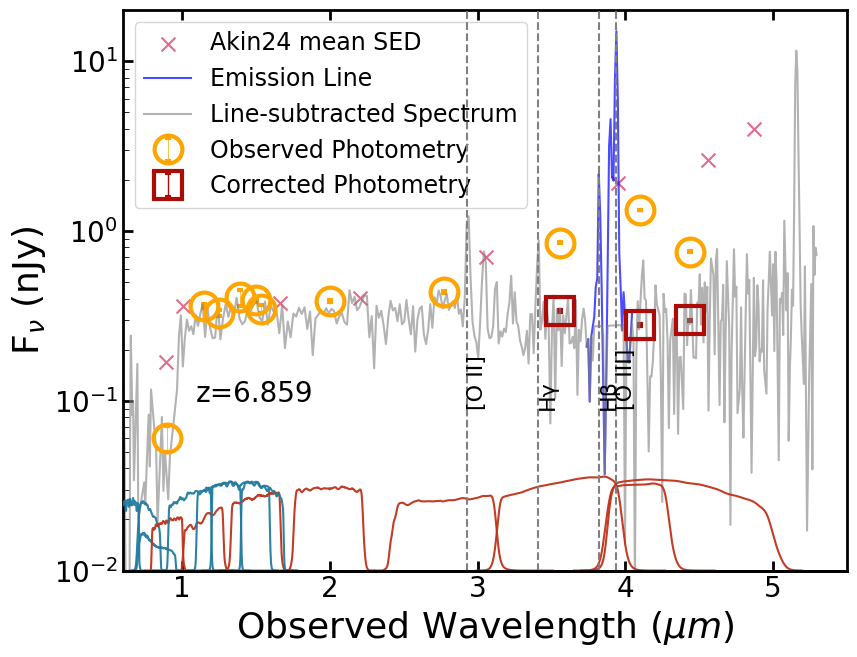

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


In [32]:
import warnings
#ignore all warnings
warnings.filterwarnings("ignore")

logwavrest =  [-0.9446945485921121, -0.8928204146799245, -0.6739518222322851, -0.5523033930127172, -0.4105158147222723, -0.29872240536039274, -0.2364959183997406, -0.20780584898094, 0.030024237730416514, 0.40586988534622126]
logfnu = [-2.0256648584585326, -1.6955762461096455, -1.6767024393167569, -1.6461417401236114, -1.4086903227272085, -0.9724877821488622, -0.8379075053929652, -0.6550865943673418, -0.4491036053475783, -0.2544440303755766]
fnu = 10**np.array(logfnu)
restwave = 10**np.array(logwavrest)

savetop = '../Figure/'
savecorpath_base = savetop + 'correction/'
os.makedirs(savetop, exist_ok=True)
os.makedirs(savecorpath_base, exist_ok=True)
filters_wavelength = {
    'F070W': 0.7, 'F090W': 0.9, 'F115W': 1.15,  'F150W': 1.5, 'F164N': 1.64, 'F105W': 1.055025, 'F125W': 1.248607, 'F140W': 1.392321, 'F160W': 1.537034, 
     'F200W': 2.0,'F277W': 2.77,  'F162M': 1.62, 'F182M': 1.82, "F187N": 1.87,
    'F300M': 3.0, 'F335M': 3.35, 'F356W': 3.56, 'F360M': 3.6, 'F210M': 2.1, 'F250M': 2.5, 'F410M': 4.1, 'F430M': 4.3, 'F140M': 1.4, 
    'F444W': 4.44, 'F460M': 4.6, 'F480M': 4.8, 'F435W': 0.435, 'F606W': 0.606, 'F775W': 0.775, 'F814W': 0.814
}
# for index, ID in enumerate(uniuid):  # Astropy Table 的行迭代

    # if ID != 672:
    #     continue
# 遍历catalog计算每个源的 β_UV 和 β_opt
beta_uv_list = []
beta_opt_list = []
beta277356 = []
beta277410 = []
zlist = []
# all_cor_ratio = {}
cor_table = catalog[catalog['uid'] == 'xwexw'].copy()

def worker(ID):
    src = np.array(catalog["uid"] == ID)
    nrssrc = np.array(nrs["uid"] == ID)
    catind = np.where(catalog["uid"] == ID)[0][0]
    # print(catalog[src]['z'])
    row = catalog[src][0]
    
    urls = [PATH_TO_FILE.format(**row) for row in nrs[nrssrc]]
    # Open the files into 1D objects, directly from the web
    sobj = {}
    for url in urls:
        # print(f'Read {url}')
        key = os.path.basename(url)
        success = False
        while not success:
            try:
                sobj[key] = msaexp.spectrum.SpectrumSampler(url)
                success = True
            except: 
                print('Failed to read, retrying...')
                
    for j, k in enumerate(sobj):
        if 'prism' in k:
            break
    # print(k)
    sp = sobj[k]
    try:
        z = np.mean(catalog['z'][src & (catalog['grade'] == 3)])
        zspec2 = catalog['zspec'][src][0]
        if(zspec2 > 0):
            z = zspec2
        if(np.isnan(z)):
            raise
    except:
        try:
            z = np.mean(catalog['z'][src])
            if(np.isnan(z)):
                raise
        except:
            z = np.mean(catalog['zphot'][src])

    # get bands that have contamination and correct the flux  --------------------------------
    contamin_bands = identify_lines_with_redshift(band_limits, lines, z)
    cor_row = row#.copy()
    
    cor_ratio = {}
    for band in contamin_bands:
        savecorpath = f'{savecorpath_base}{ID}_{band}_correction.png'
        ratio, (wavelength, flux_original), (wavelength, flux_clean) = get_linecorrect_ratio(sp, band,z, savecorpath)
        cor_row[f'f_{band.lower()}'] = cor_row[f'f_{band.lower()}'] * ratio
        cor_row[f'e_{band.lower()}'] = cor_row[f'e_{band.lower()}'] * ratio
        cor_ratio[band] = ratio
        # save to another file
    # all_cor_ratio[ID] = cor_ratio

    
    # Turn on if saved the corratro --------------------------------
    # cor_ratio = all_cor_ratio[ID]
    for band in cor_ratio.keys():
        ratio = cor_ratio[band]
        cor_row[f'f_{band.lower()}'] = cor_row[f'f_{band.lower()}'] * ratio
        cor_row[f'e_{band.lower()}'] = cor_row[f'e_{band.lower()}'] * ratio

    cor_table.add_row(cor_row)
    # Turn on if saved the corratro --------------------------------
        
    # -----------------------------------------------------------------------------------------
    # 计算 beta
    beta_uv = beta_opt = -99
    # for z_min, z_max, uv_filters, opt_filters in redshift_bands:
    #     if z_min < z <= z_max:
    #         beta_uv = calculate_beta(uv_filters, row)
    #         beta_opt = calculate_beta(opt_filters, row)
    #         break
    bands_wave = np.array([filter_wavelengths[f.upper()] for f in bands])
    short_mask = (bands_wave < 0.3645 * (1 + z))* (bands_wave > 0.1350 * (1 + z))
    
    long_mask = (bands_wave > 0.3300 * (1 + z))* (bands_wave < 0.8 * (1 + z)) 
    # long_mask2 = (bands_wave > 0.2800 * (1 + z))* (bands_wave < 0.7 * (1 + z)) 
    
    print('short bands:', bands[short_mask])
    print('long bands:', bands[long_mask])
          
    beta_uv = calculate_beta(bands[short_mask], cor_row, lowestsnr = 1)
    # beta_opt = min(calculate_beta(longbands1, cor_row, lowestsnr = 1) , calculate_beta(longbands2, cor_row, lowestsnr = 1))
    beta_opt = calculate_beta(bands[long_mask], cor_row, lowestsnr = 1)
    # beta_opt = calculate_beta(longbands1, cor_row, lowestsnr = 1)


    print(f"ID: {ID}, z: {z}, beta_UV: {beta_uv}, beta_opt: {beta_opt}")
    filter1 = ["F277W", "F356W"]
    filter2 = ["F277W", "F410M"]
    beta277356.append(calculate_beta(filter1, row))
    beta277410.append(calculate_beta(filter2, row))
    beta_uv_list.append(beta_uv)
    beta_opt_list.append(beta_opt)
    zlist.append(z)
    # -----------------------------------------------------------------------------------------
    
    # 保存SED
    plt.close()
    fig = plt.figure(figsize=(9, 7))
    large_subplot = fig.add_subplot(111)
    position = SkyCoord(catalog[catind]['ra'], catalog[catind]['dec'], frame='icrs', unit=u.deg)
    num = 0
    # names = ['ID_'+ str(ID)]    #['ID 41841','ID 41842']
    names =['Observed Photometry']
    symbollist = ['o','p','d','X','P']
    colorlist = ['orange',
                 'blue',  # 赤土
                 'green', 'black', 'purple']
    factorlist = [1, 1]
    df = catalog[catind:catind+1].to_pandas()
    NIRCAM_wave, NIRCAM_flux, NIRCAN_fluxerr,goodfilters = plot_SED_src(large_subplot, df, names[0], symbollist[0], colorlist[0], factorlist[0])
    # plot corrected phot in cor_ratio
    for kk,band in enumerate(cor_ratio.keys()):
        try:
            bandind = np.where(goodfilters == band)[0][0]
        except:
            continue
        
        if(kk == 0):
            large_subplot.errorbar(NIRCAM_wave[bandind], NIRCAM_flux[bandind]*cor_ratio[band], yerr=NIRCAN_fluxerr[bandind],
                               color='#AD0B08', ecolor='#AD0B08', fmt='s', markersize=20, elinewidth=1, capsize=2, capthick=1, markerfacecolor='none', markeredgewidth=3, label = 'Corrected Photometry')
        else:
            large_subplot.errorbar(NIRCAM_wave[bandind], NIRCAM_flux[bandind]*cor_ratio[band], yerr=NIRCAN_fluxerr[bandind],
                               color='#AD0B08', ecolor='#AD0B08', fmt='s', markersize=20, elinewidth=1, capsize=2, capthick=1, markerfacecolor='none', markeredgewidth=3)


    msk1 = (restwave < 0.3645)*(restwave > 0.1216)
    msk2 = (NIRCAM_wave/(1+z) < 0.3645)*(NIRCAM_wave/(1+z) > 0.1216)
    large_subplot.scatter(restwave*(1+z), fnu/np.nanmean(fnu[msk1])*np.nanmean(NIRCAM_flux[msk2]), s=100, c='#E16B8C', marker='x', label='Akin24 mean SED')
    large_subplot.text(0.1, 0.3, f'z={np.round(z, 3)}', fontsize=20, transform=large_subplot.transAxes)
    # large_subplot.axvline(0.3645 * (1 + z), linestyle='--', color='blue') 
    # large_subplot.axvline(0.1216 * (1 + z), linestyle='--', color='blue')

       
    flux_original = flux_original*1e-20*u.erg/u.cm**2/u.s/u.AA
    flux_clean = flux_clean*1e-20*u.erg/u.cm**2/u.s/u.AA
    flux_original_nJy = flux_original.to(u.uJy, equivalencies=u.spectral_density(wavelength*u.um))
    flux_clean_nJy = flux_clean.to(u.uJy, equivalencies=u.spectral_density(wavelength*u.um))

    mask = (flux_original_nJy.value > flux_clean_nJy.value)*(wavelength>4.5)
    plt.plot(wavelength[mask], flux_original_nJy.value[mask], alpha=0.7, label='Emission Line', color = 'blue', linestyle='-', lw = 1.5)
    mask = (flux_original_nJy.value > flux_clean_nJy.value)*(wavelength<4.5)
    plt.plot(wavelength[mask], flux_original_nJy.value[mask], alpha=0.7, color = 'blue', linestyle='-', lw = 1.5)
    plt.plot(wavelength, flux_clean_nJy.value, alpha=0.6, label='Line-subtracted Spectrum', color = 'gray', lw = 1.5)
        # for line in lines_rest.values():
        #     plt.axvline(line * (1 + z), linestyle='--', color='grey')
    

    # large_subplot.text(0.1, 0.6, catalog[ind]['method'], fontsize=20, transform = large_subplot.transAxes)
    large_subplot.set_ylim(0.01, 2e1)
    # large_subplot.set_ylim(8e-4, 3)
    large_subplot.legend(fontsize=17, loc='upper left')
    large_subplot.set_yscale('log')
    large_subplot.set_xscale('linear')
    large_subplot.set_ylabel(r'F$_\nu$ (nJy)', fontsize=26)
    large_subplot.set_xlabel(r'Observed Wavelength $(\mu m)$', fontsize=26)

    ax2 = large_subplot.twinx()
    for name in bands:
        file = '../nircam_throughputs/mean_throughputs/' + name.upper() + '_throughput.txt'
        try:
            wavelength, throughput = read_filter_data(file)
        except:
            print(f'Error reading {name}')
            continue
        wavelength = wavelength/1e4
        if(name in ['f435w', 'f606w', 'f775w', 'f814w', 'f105w', 'f125w', 'f140w', 'f160w']):
            color = '#237B9F'
            offset = 4
        else:
            color = '#C0321A'
            offset = 2 
        ax2.plot(wavelength, throughput, color=color, linestyle='-', alpha=0.95, label=f'{name} throughput')
        # 在曲线上标注波段名称
        max_throughput_index = np.argmax(throughput)
        max_wavelength = wavelength[max_throughput_index]
        max_value = throughput[max_throughput_index]

    ax2.set_ylim(0.,3.5)
    #隐藏ax2
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # ax2.spines['bottom'].set_visible(False)
    # 隐藏副轴的刻度线和刻度标签
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.yaxis.set_ticks([])
    # ax2.xaxis.set_ticks([])
    mark_emission_lines(ax2,z)
    large_subplot.set_xlim(0.6, 5.5)
    plt.tight_layout()

    plt.savefig(savetop + str(ID) +'.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    # -----------------------------------------------------------------------------------------


# # import concurrent.futures
# # with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
# #     executor.map(worker, uniuid)

# # use tqdm to show progress
from tqdm import tqdm
for ID in tqdm([666]):
    worker(ID)
# for ID in uniuid:
#     worker(ID)



  0%|          | 0/1 [00:00<?, ?it/s]

short bands: ['f105w' 'f115w' 'f125w' 'f140w' 'f150w' 'f160w' 'f200w' 'f277w']
long bands: ['f277w' 'f356w' 'f410m' 'f444w']
ID: 8219, z: 6.785, beta_UV: -1.6434597456993238, beta_opt: -0.6717873658566995


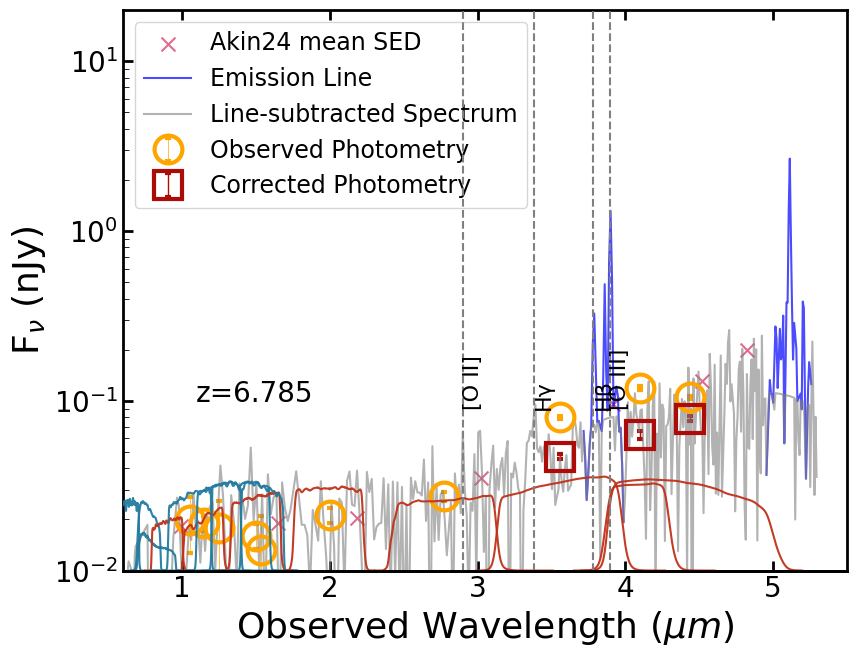

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


In [33]:
for ID in tqdm([8219]):
    worker(ID)

In [34]:
# # 将结果添加到 catalog 中
# catalog["beta_UV"] = beta_uv_list
# catalog["beta_opt"] = beta_opt_list
# catalog["beta_277356"] = beta277356
# catalog["beta_277410"] = beta277410
# catalog["z"] = zlist
# 输出结果
version = '_z2'
savepath = '/Users/zijianzhang/Astro_Data/LRD_SPEC/LRD_selection/'
catalog = Table.read(savepath + 'all_nirspec_beta_withclassify_z2.ecsv', format='ascii.ecsv')
# catalog = unique_catalog
print(catalog[["z", "beta_UV", "beta_opt"]])

# catalog.write(savepath + 'all_nirspec_beta.ecsv', format='ascii.ecsv', overwrite=True)


F115_SNR = catalog['f_f115w'] / catalog['e_f115w']
F150_SNR = catalog['f_f150w'] / catalog['e_f150w']
F200_SNR = catalog['f_f200w'] / catalog['e_f200w']
F277_SNR = catalog['f_f277w'] / catalog['e_f277w']
F356_SNR = catalog['f_f356w'] / catalog['e_f356w']
F410_SNR = catalog['f_f410m'] / catalog['e_f410m']
F444_SNR = catalog['f_f444w'] / catalog['e_f444w']
F115_mag = uJy_to_ABmag(catalog['f_f115w'], catalog['e_f115w'])[0]
F150_mag = uJy_to_ABmag(catalog['f_f150w'], catalog['e_f150w'])[0]
F200_mag = uJy_to_ABmag(catalog['f_f200w'], catalog['e_f200w'])[0]
F277_mag = uJy_to_ABmag(catalog['f_f277w'], catalog['e_f277w'])[0]
F356_mag = uJy_to_ABmag(catalog['f_f356w'], catalog['e_f356w'])[0]
F410_mag = uJy_to_ABmag(catalog['f_f410m'], catalog['e_f410m'])[0]
F444_mag = uJy_to_ABmag(catalog['f_f444w'], catalog['e_f444w'])[0]

catalog['F115_mag'] = F115_mag
catalog['F150_mag'] = F150_mag
catalog['F200_mag'] = F200_mag
catalog['F277_mag'] = F277_mag
catalog['F356_mag'] = F356_mag
catalog['F410_mag'] = F410_mag
catalog['F444_mag'] = F444_mag


colorcut = (catalog["beta_UV"] <-0.37)*(catalog["beta_opt"] > -0.)*(catalog["beta_UV"] > -10)
emil1 = ((catalog["beta_277356"] > -1)*(catalog["z"] < 8))|(catalog["z"] > 8)
# emil1 = catalog["beta_277356"] > -1
emissionline = emil1*(catalog["beta_277410"] > -1)
sele_mask_KOV24 = (F444_SNR  > 10)*colorcut#*emissionline

# red1: 确保 (F115_mag - F150_mag) 的颜色中至少一个 SNR > 3
red1 = (
    ((F115_mag - F150_mag < 0.8) & ((F115_SNR > 3) | (F150_SNR > 3)))  # 第一组条件
    & ((F200_mag - F277_mag > 0.7) & ((F200_SNR > 3) | (F277_SNR > 3)))    # 第二组条件
    & ((F200_mag - F356_mag > 1.0) & ((F200_SNR > 3) | (F356_SNR > 3)))    # 第三组条件
)

# red2: 确保每个颜色中至少有一个 SNR > 3
red2 = (
    ((F150_mag - F200_mag < 0.8) & ((F150_SNR > 3) | (F200_SNR > 3)))  # 第一组条件
    & ((F277_mag - F356_mag > 0.6) & ((F277_SNR > 3) | (F356_SNR > 3)))    # 第二组条件
    & ((F277_mag - F444_mag > 0.7) & ((F277_SNR > 3) | (F444_SNR > 3)))    # 第三组条件
)

bd_removal = F115_mag - F200_mag > -0.5
sele_mask_KOR24 = (F444_SNR  > 12)*(red1|red2)*bd_removal#*(catalog["z"] > 3)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(catalog["beta_UV"], catalog["beta_opt"], c='black', s=3, label='All sources')
ax.scatter(catalog["beta_UV"][sele_mask_KOV24], catalog["beta_opt"][sele_mask_KOV24], c='red', s=20, label='KOV24', marker='o')
ax.scatter(catalog["beta_UV"][sele_mask_KOR24], catalog["beta_opt"][sele_mask_KOR24], c='blue', s=3, label='KOR24')
ax.axhline(y=0, color='black', linestyle='--')
ax.axvline(x=-2.8, color='black', linestyle='--')
ax.axvline(x=-0.37, color='black', linestyle='--')
ax.set_xlim(-5, 2)
ax.set_ylim(-5, 5)
ax.set_xlabel(r'$\beta_{\rm UV}$')
ax.set_ylabel(r'$\beta_{\rm opt}$')
ax.legend(fontsize=12, loc='lower left')
field = 'all_nirspechighz'
plt.savefig(savepath + field + f'_beta_colorcut{version}.png')
plt.close()


# 初始化一个新的列，用于标记方法
catalog['method'] = Column([""] * len(catalog), dtype="U10")  # 新增一列，字符串类型
# 标记通过 sele_mask_KOV24 选出的源
kov24_indices = sele_mask_KOV24.nonzero()[0]  # 获取满足 sele_mask_KOV24 的索引
catalog['method'][kov24_indices] = [m + "KOV24" for m in catalog['method'][kov24_indices]]
# 标记通过 sele_mask_KOR24 选出的源
kor24_indices = sele_mask_KOR24.nonzero()[0]  # 获取满足 sele_mask_KOR24 的索引
catalog['method'][kor24_indices] = [m + "KOR24" for m in catalog['method'][kor24_indices]]
# 去除重复的逗号，标记同时满足两种条件的源
catalog['method'] = [m.strip(",").replace("KOV24KOR24", "Both") for m in catalog['method']]
# 筛选出满足任意一种条件的源
selected_sources = catalog[(catalog['method'] != "") * (catalog['method'] != "KOR24")]
for method in ['KOV24', 'KOR24', 'Both']:
    index = selected_sources['method'] == method
    print(f"{method}: {index.sum()}")

# 如果需要将结果保存为文件（如 CSV 格式）

selected_sources.write(savepath + field + f'_LRD{version}.ecsv', format='ascii.ecsv', overwrite=True)
# catalog.write(savepath +  f'all_nirspec_beta_withclassify{version}.ecsv', format='ascii.ecsv', overwrite=True)
# worker(672)


        z                beta_UV             beta_opt      
------------------ ------------------- --------------------
            2.1374 -1.8580777596441829  -1.3424505438754586
             2.173 -1.4314904653988936  -1.4051529931714932
             2.768 -1.0387178661192151  -1.8843281199666457
             2.987 -1.3983648779651594  -1.6000808300455456
             2.985 -1.7385998916617635  -1.3883079398388263
             4.449 -1.5590285146322258  -1.5056041052200184
             2.008  -2.165992507430816  -1.8746058911605892
              2.03  2.2817530270829556   1.7859433779084883
            4.5688 -1.1697808807456131  -1.5469759617161312
             5.193 -1.8834328462579346   -2.281425869913548
               ...                 ...                  ...
7.0112000000000005 -1.6586281329354295  -1.9499096839112735
            7.2066  -2.771375115525172   1.7085431213889417
 7.302350000000001  -2.016234823962699  -1.9579023517288205
           9.31025 -2.0704579840444803  

In [35]:
version = '_z2'
selected_sources = Table.read(savepath + field + f'_LRD{version}.ecsv')
catalog = Table.read(savepath +  f'all_nirspec_beta_withclassify{version}.ecsv')


In [36]:
# compare kov and kor Selection with my selection   

my_catalog_file = '/Users/zijianzhang/Astro_Data/LRD_SPEC/LRD_selection/all_nirspec_beta_withclassify_z2.ecsv'
my_catalog = Table.read(my_catalog_file, format='ascii.ecsv')
my_ra, my_dec = 'ra', 'dec'
kov_catalog_file = '/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/Kocevski_LRD.fits'
kov_catalog = Table.read(kov_catalog_file)
kov_ra, kov_dec = 'col3', 'col4'
kor_catalog_file = '/Users/zijianzhang/Astro_Data/mag_LRD/LRD_papers_table/Kokorev24_lrd_table_v1.1.fits'
kor_catalog = Table.read(kor_catalog_file)
kor_ra, kor_dec = 'ra', 'dec'


topcat_match( my_catalog_file , kov_catalog_file,
                       ra1=my_ra,  dec1=my_dec,
                       ra2=kov_ra, dec2=kov_dec, 
                       radius_arcsec=0.5, output_file = 'mysel_kov.fits' ,find='best')

topcat_match( my_catalog_file , kor_catalog_file,
                          ra1=my_ra,  dec1=my_dec,
                          ra2=kor_ra, dec2=kor_dec, 
                          radius_arcsec=0.5, output_file = 'mysel_kor.fits' ,find='best')

mysel_kov = Table.read('mysel_kov.fits')
mysel_kor = Table.read('mysel_kor.fits')
mysel_kov = mysel_kov[mysel_kov['compact']]
mysel_kor = mysel_kor[mysel_kor['compact']]

Running command: /usr/local/bin/stilts tmatch2 in1=/Users/zijianzhang/Astro_Data/LRD_SPEC/LRD_selection/all_nirspec_beta_withclassify_z2.ecsv in2=/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/Kocevski_LRD.fits matcher=sky values1="ra dec" values2="col3 col4" params=0.5 join=1and2 find=best ofmt=fits out=mysel_kov.fits


Params: Max Error(Number)/arcsec=0.5
Tuning: HEALPix k(Integer)=15
Processing: Split, BasicParallel
Attempt to locate restricted common region
Assessing range of coordinates from table 1...................................
Coverage is: 1.4241536E-4 of sky (HEALPix 1: 0030 c020 1000)
Assessing range of coordinates from table 2...................................
Coverage is: 1.2207031E-4 of sky (HEALPix 1: 0010 c020 1000)
Potential match region: 1.2207031E-4 of sky (HEALPix 1: 0010 c020 1000)
Counting rows in match region for table 1.....................................
4381 rows in match region
Counting rows in match region for table 2.....................................
341 rows in match region
Binning rows for table 2......................................................
418 row refs for 341 rows in 413 bins
(average bin occupancy 1.0121065)
Scanning rows for table 1.....................................................
Eliminating multiple row references...............................

Running command: /usr/local/bin/stilts tmatch2 in1=/Users/zijianzhang/Astro_Data/LRD_SPEC/LRD_selection/all_nirspec_beta_withclassify_z2.ecsv in2=/Users/zijianzhang/Astro_Data/mag_LRD/LRD_papers_table/Kokorev24_lrd_table_v1.1.fits matcher=sky values1="ra dec" values2="ra dec" params=0.5 join=1and2 find=best ofmt=fits out=mysel_kor.fits


Params: Max Error(Number)/arcsec=0.5
Tuning: HEALPix k(Integer)=15
Processing: Split, BasicParallel
Attempt to locate restricted common region
Assessing range of coordinates from table 1...................................
Coverage is: 1.4241536E-4 of sky (HEALPix 1: 0030 c020 1000)
Assessing range of coordinates from table 2...................................
Coverage is: 1.2207031E-4 of sky (HEALPix 1: 0010 4020 1000)
Potential match region: 1.0172526E-4 of sky (HEALPix 1: 0010 4020 1000)
Counting rows in match region for table 1.....................................
3862 rows in match region
Counting rows in match region for table 2.....................................
259 rows in match region
Binning rows for table 2......................................................
1/260 rows excluded (out of match region)
303 row refs for 260 rows in 278 bins
(average bin occupancy 1.089928)
Scanning rows for table 1.....................................................
Eliminating multiple row 

In [16]:
# np.where(((mysel_kov['method'].value == 'Both') | (mysel_kov['method'].value == 'KOV24')).mask)
print(len(mysel_kov))
print(len(np.where((mysel_kov['method'] == 'Both') | (mysel_kov['method'] == 'KOV24'))[0]))

print(len(mysel_kor))
print(len(np.where((mysel_kor['method'] == 'Both') | (mysel_kor['method'] == 'KOV24'))[0]))

# np.where((mysel_kor['method'].value == '').mask)

NameError: name 'mysel_kov' is not defined

In [38]:
not_sel = mysel_kov[(mysel_kov['method'] != 'Both') & (mysel_kov['method'] != 'KOV24')]
# colorcut_ = (not_sel["beta_UV"] <-0.37)*(not_sel["beta_opt"] > -0.)*(not_sel["beta_UV"] > -10)
# # emil1_ = ((catalog["beta_277356"] > -1)*(catalog["z"] < 8))|(catalog["z"] > 8)
# # emil1 = catalog["beta_277356"] > -1
# # emissionline = emil1*(catalog["beta_277410"] > -1)
# F444_SNR_ = not_sel['f_f444w'] / not_sel['e_f444w']
# sele_mask_KOV24 = (F444_SNR_  > 10)*colorcut_#*emissionline
# sele_mask_KOV24 
# # not_sel.keys()
keys = ['jname','ndup','uid','file','root','srcid','nGr','Grating','grade','zfit','z','col5','comment','References','beta_UV','beta_opt','beta_277356','beta_277410','F115_mag','F150_mag','F200_mag','F277_mag','F356_mag','F410_mag','F444_mag','method','compact']
not_sel[keys]

jname,ndup,uid,file,root,srcid,nGr,Grating,grade,zfit,z,col5,comment,References,beta_UV,beta_opt,beta_277356,beta_277410,F115_mag,F150_mag,F200_mag,F277_mag,F356_mag,F410_mag,F444_mag,method,compact
bytes20,int64,int64,bytes55,bytes22,int64,int64,bytes29,int64,float64,float64,float32,bytes66,bytes48,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes5,bool
j100030.20p022322.96,1,1300,cosmos-transients-v3_prism-clear_6585_66964.spec.fits,cosmos-transients-v3,66964,0,--,3,7.0363,7.036,7.03,strong LAE,DKo24 z=N/A,-2.443004526006145,-0.01291791351467153,-0.3485445294467138,-0.1960439985145922,27.623302422419474,27.945858793535532,28.004210899794508,27.832096492685086,27.166122286010214,26.25440957764308,26.485232711262018,KOR24,True
j033229.13m274741.24,4,9334,jades-gds-wide2-v3_prism-clear_1180_3044.spec.fits,jades-gds-wide2-v3,3044,3,G140M G235M G395M,3,4.1141,4.116,7.51,Redshifts match v2 grade=3,-,-1.6369458630851563,-1.2340010415233036,-0.05178916070706983,0.053869716401379934,29.139564079289592,28.97879262861516,28.8753109157196,28.156145830454598,27.920017319350716,28.025349794519173,27.80681300647469,--,True
j141929.25p525249.57,2,9656,rubies-egs63-nod-v3_prism-clear_4233_57375.spec.fits,rubies-egs63-nod-v3,57375,1,G395M,3,5.6747,5.672,5.68,Redshift matches rubies-egs63-v3_prism-clear_4233_57375 z=5.6766,DKo24 z=5.680,-2.2467416901311275,-0.13934444515426303,-0.8979717779153423,-0.5161021455887865,29.011983656145144,29.182364054872608,29.16282585813687,28.780839513496097,28.293025476303306,28.149054837823243,27.512868914069863,--,True
j021731.60m051813.47,2,13333,rubies-uds42-nod-v3_prism-clear_4233_10036.spec.fits,rubies-uds42-nod-v3,10036,1,G395M,3,3.8179,3.81775,4.51,Redshift matches rubies-uds42-v3_g395m-f290lp_4233_10036 z=3.8052,DKo24 z=N/A,-2.9563121111680246,-0.4615739200469457,0.4072891091890479,-0.06354790659559131,28.55503316819117,28.715704124134692,27.224849456317163,26.697394729516486,25.94503393879962,26.07344199579351,25.931621294441346,--,True
j033208.37m275107.89,1,14531,gds-barrufet-s67-v3_prism-clear_2198_4820.spec.fits,gds-barrufet-s67-v3,4820,0,--,3,3.7966,3.797,4.36,Redshifts match v2 grade=3,DKo24 z=N/A,-1.490206813015395,-0.06791229444836899,-0.8533144279147378,-0.8194533644262059,27.38997516896942,27.320376344600454,26.78014340288694,25.90068060298236,25.31910027573302,25.398050808717578,25.33571622678733,KOR24,True
j001432.87m302422.90,1,16387,uncover-v3_prism-clear_2561_10646.spec.fits,uncover-v3,10646,0,--,3,8.5115,8.511,8.65,Redshifts match v2 grade=3,DKo24 z=N/A,-2.0698793021464725,-2.625525960116236,-1.3598404645805873,-99.0,26.29247897530012,25.363903743794605,25.434778612154872,25.412427028666567,25.238031200885157,--,24.184704217171372,--,True
j033239.87m274619.33,4,18807,jades-gds-wide-v3_prism-clear_1180_9597.spec.fits,jades-gds-wide-v3,9597,3,G140M G235M G395M,3,6.309,6.311,6.34,Redshifts match v2 grade=3,DKo24 z=N/A ; CSi23 z=N/A,-1.7403890092725791,-0.39173818079637435,-0.9965314872444505,-0.7764573972993142,27.908194303740565,27.796154903244595,27.780554976763447,27.45512218067561,26.271829202824037,26.934186414024822,26.17259230851067,KOR24,True
j021754.73m051007.39,2,19937,rubies-uds32-nod-v3_prism-clear_4233_125917.spec.fits,rubies-uds32-nod-v3,125917,1,G395M,3,6.042,6.0423,5.77,Redshift matches rubies-uds32-v3_prism-clear_4233_125917 z=6.0426,DKo24 z=N/A,-2.4123601599948765,-0.07354922850843715,-0.24664567496975665,-0.3997633344925385,28.269688618735888,28.6043381847763,28.567750575138792,28.13931237380718,27.32545700995371,27.457995260427715,26.85923100142015,KOR24,True
j021748.81m051614.58,2,20412,rubies-uds33-nod-v3_prism-clear_4233_29813.spec.fits,rubies-uds33-nod-v3,29813,1,G395M,3,5.4435,5.4435,5.29,Redshift matches rubies-uds33-v3_prism-clear_4233_29813 z=5.4435,DKo24 z=N/A,-2.5721890641140224,-0.49437938513530066,-0.9033742379748888,-0.6619002022321947,28.380241174034868,28.441113665952845,28.333500236981607,27.68215406130703,27.

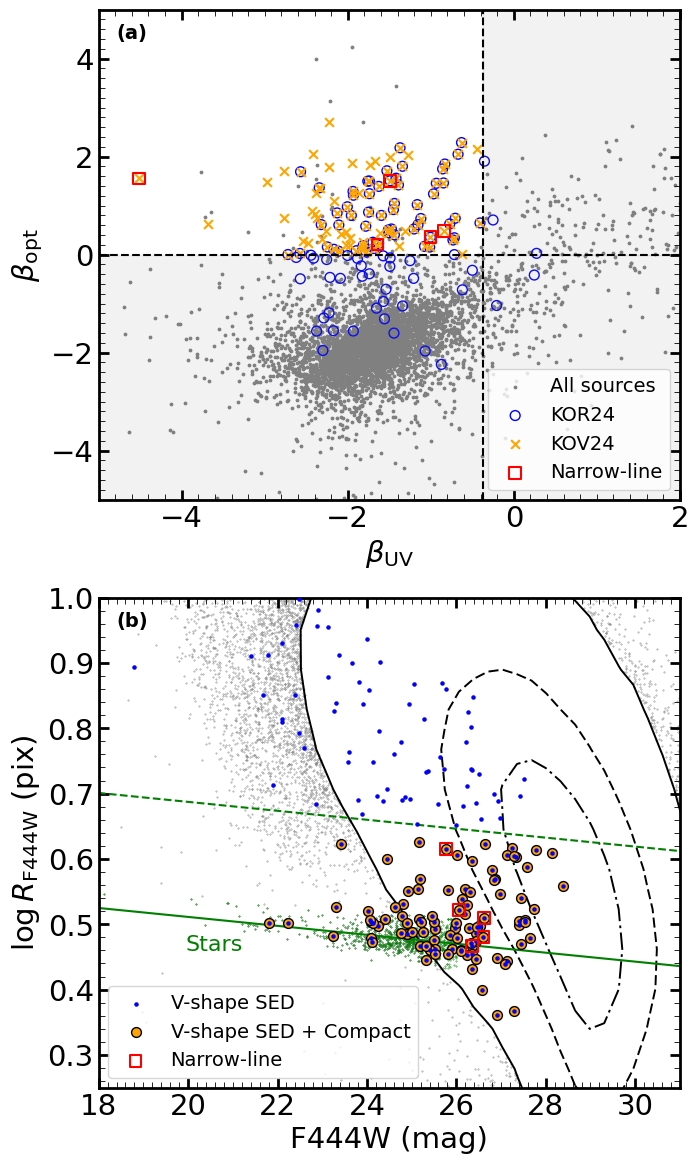

In [39]:
from sklearn.neighbors import KernelDensity
# narrowid = np.array([    1236,     1294,     1465,     3044,     4273,     9925,
#           13560,    26611,    31078,    40800,    53254,    53692,
#           55637,    57375,   125917,   830237,   916674,   927271,
#          928474,   961025, 10013560])
fig, axs = plt.subplots(2, 1, figsize=(7.5, 14))
ax1, ax2 = axs

narrowid = np.array([8219,12329,16321,20547,22015])
narrow_mask = [ID in narrowid for ID in catalog['uid']]
iscompact = catalog['compact'] == True
narrow_mask_right = [ID in narrowid for ID in selected_sources['uid']]

ax1.scatter(catalog["beta_UV"][~(sele_mask_KOR24|sele_mask_KOV24)], catalog["beta_opt"][~(sele_mask_KOR24|sele_mask_KOV24)], c='gray', s=3, label='All sources')
ax1.scatter(catalog["beta_UV"][sele_mask_KOR24*iscompact], catalog["beta_opt"][sele_mask_KOR24*iscompact],  s=50, label='KOR24', facecolors='none', edgecolors='blue')
# ax1.scatter(catalog["beta_UV"][sele_mask_KOV24*~iscompact], catalog["beta_opt"][sele_mask_KOV24*~iscompact],  s=30, label='KOR24', facecolors='none', edgecolors='purple')
ax1.scatter(catalog["beta_UV"][sele_mask_KOV24*iscompact], catalog["beta_opt"][sele_mask_KOV24*iscompact], c='orange', s=40, label='KOV24', marker='x')
ax1.scatter(catalog["beta_UV"][narrow_mask], catalog["beta_opt"][narrow_mask], s=70, label='Narrow-line', marker='s', facecolors='none', edgecolors='red', linewidths=1.5)
notlrdid = [397,1236,1465,3044,3640,9925,150029,160133,201793,214839]
notlrdmask = np.array([ID in notlrdid for ID in catalog['srcid']])
# ax.scatter(catalog["beta_UV"][notlrdmask], catalog["beta_opt"][notlrdmask], c='gray', s=50, label='Not LRD', marker='o')

#set minor ticks to 0.2
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))


ax1.axhline(y=0, color='black', linestyle='--')
# ax.axvline(x=-2.8, color='black', linestyle='--')
ax1.axvline(x=-0.37, color='black', linestyle='--')
# ax1.fill_between(x, -1, 1, where=(x <= -0.37), color='gray', alpha=0.3)
y = np.linspace(0, 10, 100)
ax1.fill_betweenx(y, -0.37, 2, color='gray', alpha=0.1)
ax1.fill_betweenx(-y, -8, 2, color='gray', alpha=0.1)


ax1.set_xlim(-5, 2)
ax1.set_ylim(-5, 5)
ax1.set_xlabel(r'$\beta_{\rm UV}$')
ax1.set_ylabel(r'$\beta_{\rm opt}$')
ax1.legend(fontsize = 14, loc = 'lower right')
# plt.savefig(savepath + field + '_beta_colorcut.png')


# selection compace
x_all = astrodeep_src['F444W']
y_all = np.log10(astrodeep_src['r50_SE'])
x_sel_candi = selected_sources['F444_mag']
y_sel_candi = np.log10(selected_sources['r50_SE'])

mask = np.isnan(x_all) | np.isnan(y_all) | np.isinf(x_all) | np.isinf(y_all)
x_all = x_all[~mask]
y_all = y_all[~mask]
xy = np.vstack([x_all, y_all]).T
# 使用 scikit-learn 的 KernelDensity
# kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde.fit(xy)
# # 创建网格
# xi, yi = np.linspace(x_all.min(), x_all.max(), 20), np.linspace(y_all.min(), y_all.max(), 20)
# xi, yi = np.meshgrid(xi, yi)
# xy_grid = np.vstack([xi.flatten(), yi.flatten()]).T
# zi = np.exp(kde.score_samples(xy_grid))
# sorted_zi = np.sort(zi.flatten())  # 将数据展平并排序
# cumulative = np.cumsum(sorted_zi)  # 累计求和，得到 CDF
# cumulative /= cumulative[-1]       # 归一化到 [0, 1] 范围
# # 找到 0.95, 0.68, 0.35 对应的值
# level_95 = sorted_zi[np.searchsorted(cumulative, 1 - 0.95)]
# level_68 = sorted_zi[np.searchsorted(cumulative, 1 - 0.68)]
# level_35 = sorted_zi[np.searchsorted(cumulative, 1 - 0.35)]
# 画等高线
contour = plt.contour(xi, yi, zi.reshape(xi.shape), levels=[level_95, level_68,level_35 ], 
            linewidths=[1.4, 1.4, 1.4], colors=["black", "black", "black"],
            linestyles=["-", "--", "-."])
contour_lines = contour.collections[0].get_paths()
# Determine points outside the contour
outside_points = []
for i in range(len(x_all)):
    point = (x_all[i], y_all[i])
    is_inside = any(line.contains_point(point) for line in contour_lines)
    if not is_inside:
        outside_points.append(i)
ax2.scatter(x_all[outside_points], y_all[outside_points], s=0.1, c='gray')

x = np.linspace(15, 33, 100)
y = -0.005*x + 0.6
mask = (x_all  < 26) & (np.abs(y_all - (-0.005*x_all  + 0.6)) <= 0.04)
star_x = x_all[mask]
star_y = y_all[mask]
def linear_func(x, a, b):
    return a * x + b

# 进行拟合
params, _ = curve_fit(linear_func, star_x, star_y)
#params: [-0.00684396,  0.64809841]
ax2.scatter(star_x, star_y, s = 0.1, c = 'green')
ax2.plot(x, linear_func(x, *params), c = 'green')
ax2.plot(x, linear_func(x, *params) + np.log10(1.5), c = 'green', ls = '--')
mask_lrd = (linear_func(x_sel_candi, *params) + np.log10(1.5) > y_sel_candi)
ax2.scatter(x_sel_candi, y_sel_candi, s = 5, c = 'blue', label = 'V-shape SED', zorder = 5)
ax2.scatter(x_sel_candi[mask_lrd], y_sel_candi[mask_lrd], s = 50, c = 'orange', edgecolors = 'black', label = 'V-shape SED + Compact', zorder = 2)
ax2.scatter(x_sel_candi[narrow_mask_right], y_sel_candi[narrow_mask_right], s=70, label='Narrow-line', marker='s', facecolors='none', edgecolors='red', linewidths=1.5, zorder = 10)

ax2.text(0.15, 0.28, 'Stars', fontsize = 16, color = 'green', transform = ax2.transAxes)
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

# plt.plot(x, y, c = 'red')
ax2.legend(fontsize = 14, loc = 'lower left')
ax2.set_xlim(18, 31)
ax2.set_ylim(0.25, 1.)
ax2.set_xlabel('F444W (mag)')
ax2.set_ylabel(r'$\log R_{\rm F444W}$ (pix)')
# plt.yscale('log')

ax1.text(0.03, 0.94, '(a)', fontsize=14, transform=ax1.transAxes, color='black', weight='bold')
ax2.text(0.03, 0.94, '(b)', fontsize=14, transform=ax2.transAxes, color='black', weight='bold')

savepath = '../Figure/'
plt.savefig(savepath + 'LRD_selection.pdf', dpi = 300, bbox_inches='tight')

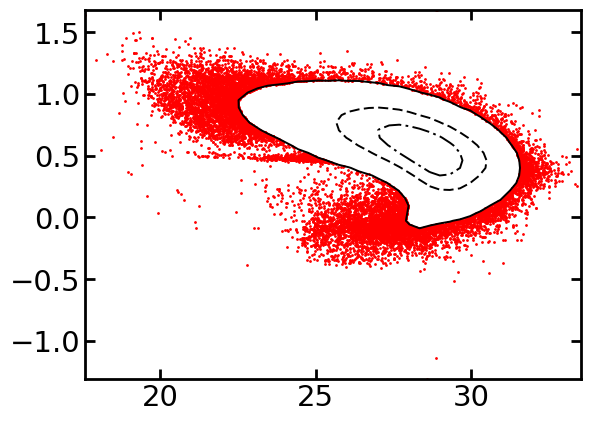

In [38]:
# 上图的等高线在这生成

x = x_all
y = y_all
xy = np.vstack([x, y]).T
# 使用 scikit-learn 的 KernelDensity
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(xy)

# 创建网格
xi, yi = np.linspace(x.min(), x.max(), 50), np.linspace(y.min(), y.max(), 50)
xi, yi = np.meshgrid(xi, yi)
xy_grid = np.vstack([xi.flatten(), yi.flatten()]).T

# 计算每个网格点的密度
zi = np.exp(kde.score_samples(xy_grid))

sorted_zi = np.sort(zi.flatten())  # 将数据展平并排序
cumulative = np.cumsum(sorted_zi)  # 累计求和，得到 CDF
cumulative /= cumulative[-1]       # 归一化到 [0, 1] 范围

# 找到 0.95, 0.68, 0.35 对应的值
level_95 = sorted_zi[np.searchsorted(cumulative, 1 - 0.95)]
level_68 = sorted_zi[np.searchsorted(cumulative, 1 - 0.68)]
level_35 = sorted_zi[np.searchsorted(cumulative, 1 - 0.35)]

# 画等高线
contour = plt.contour(xi, yi, zi.reshape(xi.shape), levels=[level_95, level_68,level_35 ], 
            linewidths=[1.4, 1.4, 1.4], colors=["black", "black", "black"],
            linestyles=["-", "--", "-."])


contour_lines = contour.collections[0].get_paths()

# Determine points outside the contour
outside_points = []
for i in range(len(x)):
    point = (x[i], y[i])
    is_inside = any(line.contains_point(point) for line in contour_lines)
    if not is_inside:
        outside_points.append(i)
plt.scatter(x[outside_points], y[outside_points], c='red', s=1)
